# Using an Experiment Class for Reproducible Experiments

In [1]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

In [2]:
%matplotlib inline

In [3]:
# here the usual imports. If any of the imports fails, make sure that pynoddy is installed
# properly, ideally with 'python setup.py develop' or 'python setup.py install'
import sys, os
import matplotlib.pyplot as plt
import numpy as np
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
import pynoddy.history
import pynoddy.experiment
reload(pynoddy.experiment)
rcParams.update({'font.size': 15})

/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy-0.15.1-py2.7-macosx-10.9-x86_64.egg/scipy/stats/_continuous_distns.py:3959: RuntimeWarning: overflow encountered in exp
  return vonmises_cython.von_mises_cdf(kappa, x)
/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy-0.15.1-py2.7-macosx-10.9-x86_64.egg/scipy/stats/_continuous_distns.py:3959: RuntimeWarning: invalid value encountered in divide
  return vonmises_cython.von_mises_cdf(kappa, x)


## Defining an experiment

We are considering the following scenario: we defined a kinematic model of a prospective geological unit at depth. As we know that the estimates of the (kinematic) model parameters contain a high degree of uncertainty, we would like to represent this uncertainty with the model.

Our approach is here to perform a randomised uncertainty propagation analysis with a Monte Carlo sampling method. Results should be presented in several figures (2-D slice plots and a VTK representation in 3-D).

To perform this analysis, we need to perform the following steps (see main paper for more details):

1. Define kinematic model parameters and construct the initial (base) model; 
2. Assign probability distributions (and possible parameter correlations) to relevant uncertain input parameters;
3. Generate a set of n random realisations, repeating the following steps: 
    1. Draw a randomised input parameter set from the parameter distribu- tion;
    2. Generate a model with this parameter set;
    3. Analyse the generated model and store results; 
4. Finally: perform postprocessing, generate figures of results

It would be possible to write a Python script to perform all of these steps in one go. However, we will here take another path and use the implementation in a Pynoddy Experiment class. Initially, this requires more work and a careful definition of the experiment - but, finally, it will enable a higher level of flexibility, extensibility, and reproducibility.



## Setting up the experiment class

We use an experiment class that is pre-defined in the pynoddy.experiment module and inherits many base functions from the Experiment-class definition. 

## Loading an example model from the Virtual Explorer Atlas

As in the last example, we will use a model from the Virtual Explorer Atlas as an examlpe model for this simulation. We use a model for a fold interference structure. A discretised 3-D version of this model (from the Virtual Explorer website) is presented in the figure below. The model represents a fold interference pattern of "Type 1" according to the definition of Ramsey (1967).

![](http://tectonique.net/asg/ch3/ch3_7/jpeg/geol/typeb.jpg)

Instead of loading the model into a history object, we are now directly creating an experiment object for the type of uncertainty analysis:

In [5]:
reload(pynoddy.history)
reload(pynoddy.experiment)

from pynoddy.experiment import UncertaintyAnalysis
reload(UncertaintyAnalysis)
# model_url = 'http://virtualexplorer.com.au/special/noddyatlas/ch3/ch3_7/his/typeb.his'
model_url = 'http://tectonique.net/asg/ch3/ch3_7/his/typeb.his'
ue = UncertaintyAnalysis.UncertaintyAnalysis(url = model_url)
# ue = pynoddy.experiment.UncertaintyAnalysis(history = "typeb_tmp.his")

TypeError: __init__() takes at least 3 arguments (1 given)

For simpler visualisation in this notebook, we will analyse the following steps in a section view of the model.

We consider a section in y-direction through the model:

In [94]:
ue.write_history("typeb_tmp3.his")

In [95]:
ue.write_history("typeb_tmp2.his")

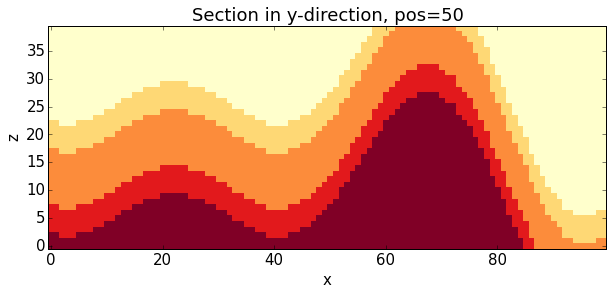

In [108]:
ue.change_cube_size(100)
ue.plot_section('y')

Before we start to draw random realisations of the model, we should first store the base state of the model for later reference. This is simply possibel with the freeze() method which stores the current state of the model as the "base-state":

In [109]:
ue.freeze()

We now intialise the random generator. We can directly assign a random seed to simplify reproducibility (note that this is not *essential*, as it would be for the definition in a script function: the random state is preserved within the model and could be retrieved at a later stage, as well!):

In [110]:
ue.set_random_seed(12345)

The next step is to define probability distributions to the relevant event parameters. Let's first look at the different events:

In [111]:
ue.info(events_only = True)

This model consists of 3 events:
	(1) - STRATIGRAPHY
	(2) - FOLD
	(3) - FOLD



In [112]:
ev2 = ue.events[2]

In [113]:
ev2.properties

{'Amplitude': 1250.0,
 'Cylindricity': 0.0,
 'Dip': 90.0,
 'Dip Direction': 90.0,
 'Pitch': 0.0,
 'Single Fold': 'FALSE',
 'Type': 'Sine',
 'Wavelength': 5000.0,
 'X': 1000.0,
 'Y': 0.0,
 'Z': 0.0}

Next, we define the probability distributions for the uncertain input parameters:

In [114]:
param_stats = [{'event' : 2, 
              'parameter': 'Amplitude',
              'stdev': 100.0,
              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'Wavelength',
              'stdev': 500.0,
              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'X',
              'stdev': 500.0,
              'type': 'normal'}]

ue.set_parameter_statistics(param_stats)

In [115]:
resolution = 100
ue.change_cube_size(resolution)
tmp = ue.get_section('y')
prob_4 = np.zeros_like(tmp.block[:,:,:])
n_draws = 10


for i in range(n_draws):
    ue.random_draw()
    tmp = ue.get_section('y', resolution = resolution)
    prob_4 += (tmp.block[:,:,:] == 4)

# Normalise
prob_4 = prob_4 / float(n_draws)

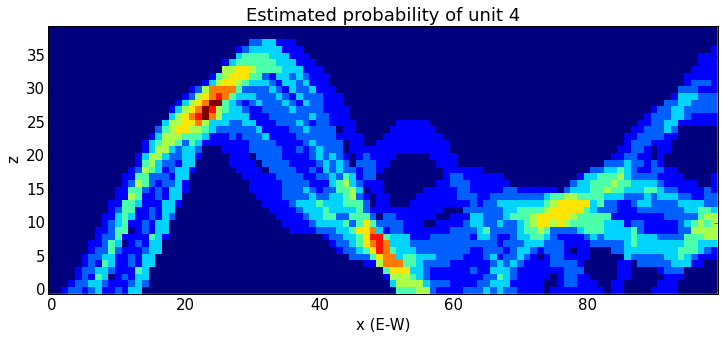

In [116]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
ax.imshow(prob_4.transpose()[:,0,:], 
           origin = 'lower left',
           interpolation = 'none')
plt.title("Estimated probability of unit 4")
plt.xlabel("x (E-W)")
plt.ylabel("z")

In [27]:
reload(pynoddy.history)
reload(pynoddy.output)
reload(pynoddy.experiment)
model_url = 'http://virtualexplorer.com.au/special/noddyatlas/ch3/ch3_7/his/typeb.his'
# ue = pynoddy.experiment.UncertaintyAnalysis(url = model_url)
ue = pynoddy.experiment.UncertaintyAnalysis(history = "typeb_tmp.his")
ue.change_cube_size(100)
# tmp = ue.get_section('y')
# tmp.plot_section('y', position = 0, data = prob_4, cmap = 'jet')

 STRATIGRAPHY
 FOLD
 FOLD


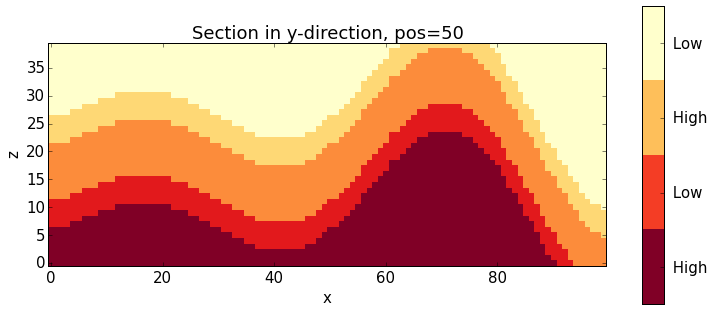

In [352]:
ue.plot_section('y')

In [76]:
ue.export_to_vtk(vtk_filename = "typeb")

In [77]:
ue.export_to_vtk(vtk_filename = "prob4", data = prob_4)

In [78]:
pwd

u'/Users/flow/git/pynoddy/docs/notebooks'

In [210]:
block = ue.get_section('y')

In [231]:
tmp = np.zeros_like(block.block)
tmp += (block.block[:,0,:] == 2)

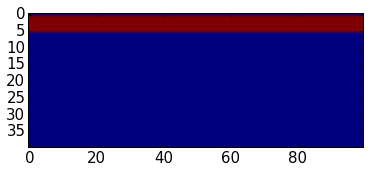

In [232]:
plt.imshow(tmp[:,0,:].transpose())

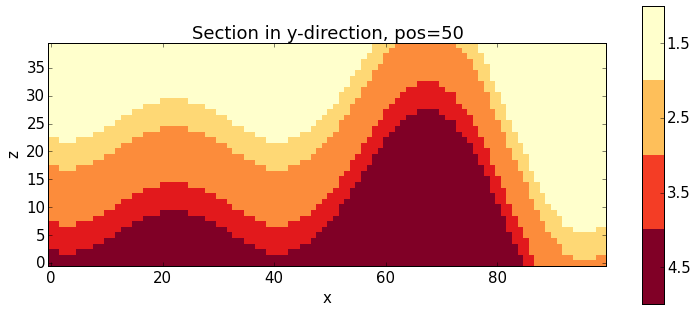

In [225]:
block.plot_section('y')

<matplotlib.colorbar.Colorbar instance at 0x10eb97b48>

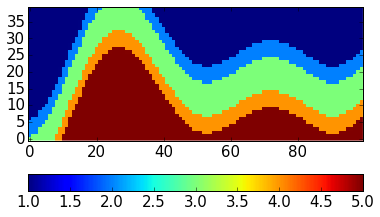

In [233]:
plt.imshow(block.block[:,0,:].transpose(), origin = 'lower left', interpolation = 'none')
plt.colorbar(orientation = "horizontal")

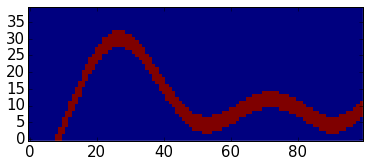

In [237]:
# filter out unit 4:
test = np.zeros_like(block.block[:,0,:])
test += (block.block[:,0,:] == 4)
plt.imshow(test.transpose(), origin = 'lower left', interpolation = 'none')

In [268]:
ue.write_history("typeb_tmp.his")

In [362]:
ue.events[2].event_lines[-1]

'\tName\t= Fold\n'

In [386]:
for i,line in enumerate(ue.history_lines):
    if 'BlockOptions' in line:
        print ue.history_lines[i-1] == '\n'

True


In [378]:
list.insert??

In [382]:
a = ['a', 'b', 'c']

In [383]:
print a[2]
a.insert(2,'2')

c


In [381]:
a

['a', 'b', '2', 'c']